# Stability Analysis

In this notebook, we plotted cross-entropy with different hyper-parameters.
We did this to assess the stability of our method across different configurations.

Before it runs, you will need to ensure that you have downloaded/produced the results from the "run_CE_experiments.py" script.
Drop the jsons into a directory (e.g. "Results/hyperparam_experiments") and then point the project_config's "EXPERIMENT_RESULTS" variable to that directory.

Our results are provided across three zip files in the *hyperparam_experiments* directory.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
from datetime import datetime
import numpy as np
import json

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [2]:
from helper_functions import check_dir

with open("../project-config.json") as config_file:
    project_config = json.load(config_file)
    
DB_FP = project_config["DB_FP"]
    
results_fp = project_config["EXPERIMENT_RESULTS"]

out_fp = os.path.join(results_fp, "graphs")
check_dir(out_fp)

In [3]:
def get_CE_comparisons(fp):
    with open(fp) as results_file:
        results = json.load(results_file)

    comparisons = [{gsnap: {gtest: {datetime.strptime(w, "%Y-%m-%d"): pd.Series(run[gsnap][gtest][w]) for w in run[gsnap][gtest]} for gtest in run[gsnap]} for gsnap in run} for run in results["comparisons"]]
    return comparisons

In [4]:
def get_CE_meta(fp):
    with open(fp) as results_file:
        results = json.load(results_file)

    meta = [{metatype: {party: pd.Series({datetime.strptime(w, "%Y-%m-%d"): run[metatype][party][w] for w in run[metatype][party]}) for party in run[metatype]} for metatype in run} for run in results["meta"]]
    return meta

In [5]:
def get_meta_mean_and_std(meta, metatype, gname):
    all_runs = pd.DataFrame([run[metatype][gname] for run in meta]).T
    
    return all_runs.mean(axis=1), all_runs.std(axis=1)

In [6]:
from mp_sampling import get_ce_mean_and_std, plot_group_similarity_across_runs_simple

# Window Type

First section is about window type

### Meta Analysis of Contribution vs Time Windows

In [7]:
%%time
# Read in all contributions
import sqlite3

sql_get_all_posts ="""
SELECT c.uid, m.name, m.PimsId, p.party, d.date, c.body, c.topic, c.section, s.tmay_deal, s.benn_act, s.ref_stance, s.constituency_leave, c.usas_file
FROM contributions as c
INNER JOIN members as m
ON m.PimsId = c.member
INNER JOIN debates as d
ON d.uid = c.debate
INNER JOIN member_party as p
ON p.PimsId = m.PimsId
INNER JOIN member_stances as s
ON s.PimsId = m.PimsId
WHERE (d.date BETWEEN date("2015-05-01") AND date("2019-09-10"))
AND (((d.date BETWEEN p.start AND p.end) AND NOT (p.end IS NULL))
OR ((d.date >= p.start) AND (p.end IS NULL)));""".strip()

conn = sqlite3.connect(DB_FP)
curs = conn.cursor()

# Gets all the contributions and creates a nice dataframe
all_contributions = pd.read_sql_query(sql_get_all_posts, conn)
all_contributions.columns = ['uid', 'name', 'PimsId', 'party', 'date', 'text', 'topic', 'section', 'tmay_deal', 'benn_act', 'ref_stance', 'constituency_leave', 'usas_file']
all_contributions.set_index("uid", inplace=True)
convert_to_date = lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S")
all_contributions['date'] = all_contributions['date'].apply(convert_to_date)
all_contributions.sort_values("date", inplace=True)

Wall time: 7.49 s


In [8]:
%%time
from helper_functions import get_time_windows, get_contribution_windows

# Get the contribs per month time window
contribs_per_month = pd.Series({datetime.strptime(window, "%Y/%m/%d"): contribs for window, contribs in get_time_windows(all_contributions, 30, 30)})

# See what the average number of contributions per time window is
print("Average contribs per month: ", contribs_per_month.apply(len).mean())

Average contribs per month:  5357.307692307692
Wall time: 48.5 s


In [9]:
# Get a similarly sized contribution window
contribs_per_window = pd.Series({datetime.strptime(window, "%Y/%m/%d"): contribs for window, contribs in get_contribution_windows(all_contributions, 5000, 5000)})

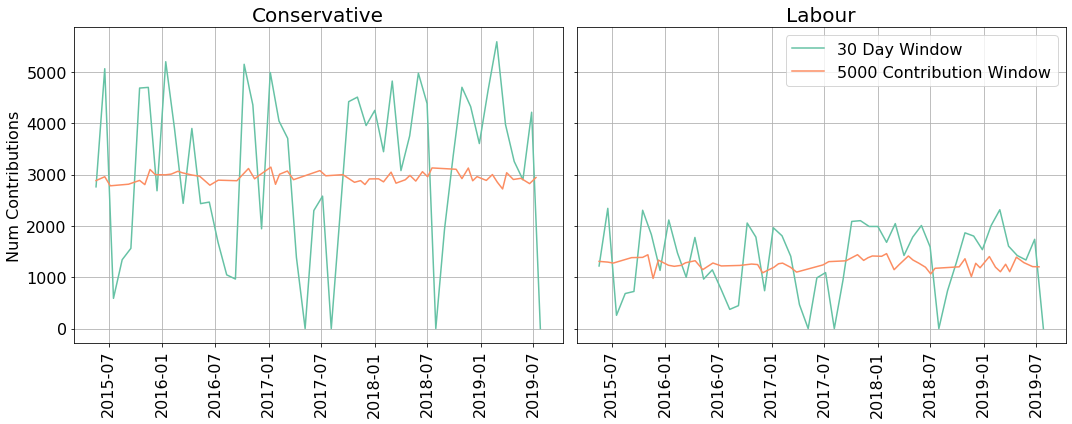

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#66c2a5", "#fc8d62"]

curr = contribs_per_month.apply(lambda x: len(x[x["party"] == "Conservative"]))
ax1.plot(curr, color=colour_list[0], label="Conservative 30 Day Time Window")
curr = contribs_per_window.apply(lambda x: len(x[x["party"] == "Conservative"]))
ax1.plot(curr, color=colour_list[1], label="Conservative 5000 Contribution Time Window")
ax1.grid()
ax1.tick_params(axis='x', rotation=90)
ax1.title.set_text('Conservative')

curr = contribs_per_month.apply(lambda x: len(x[x["party"] == "Labour"]))
ax2.plot(curr, color=colour_list[0], label="30 Day Window")
curr = contribs_per_window.apply(lambda x: len(x[x["party"] == "Labour"]))
ax2.plot(curr, color=colour_list[1], label="5000 Contribution Window")
ax2.grid()
ax2.legend(loc="upper left")
ax2.tick_params(axis='x', rotation=90)
ax2.title.set_text('Labour')

plt.setp(ax1.title, fontsize=20)
plt.setp(ax2.title, fontsize=20)

ax2.legend(fontsize=16)

plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)

ax1.set_ylabel("Num Contributions", fontsize=16)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "window_type_meta.pdf"))

plt.show()

# Sampling Techniques

Next we look at different sampling techniques: namely sampling with and without a maximum limit of contributions per MP.

### Meta Analysis of Sampling With and Without Limit

In [11]:
meta_wlim_5 = get_CE_meta(os.path.join(results_fp, "eu_CE_15000_5000_w5_lim_unbalanced_5_runs.json"))
meta_wlim_20 = get_CE_meta(os.path.join(results_fp, "eu_CE_15000_5000_w20_lim_unbalanced_5_runs.json"))
meta_n_lim = get_CE_meta(os.path.join(results_fp, "eu_CE_15000_5000_n_lim_unbalanced_5_runs.json"))

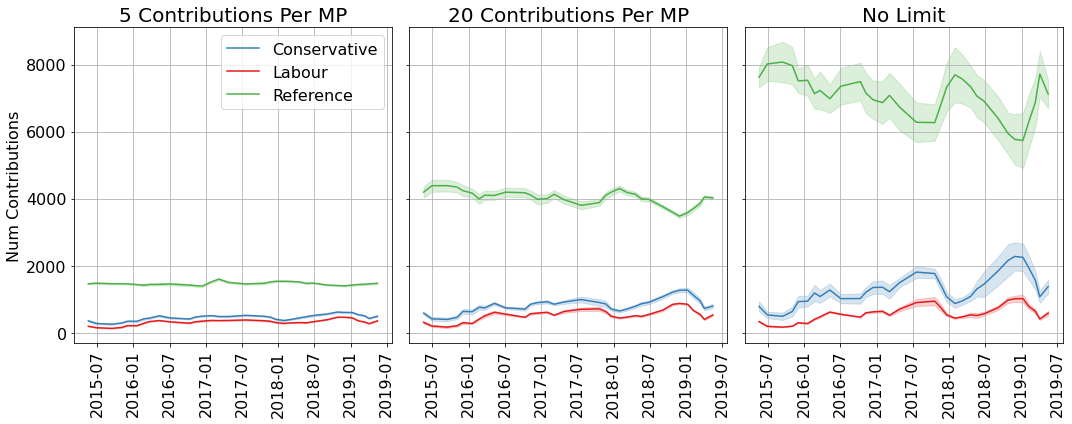

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#377eb8", "#4daf4a", "#e41a1c", "#984ea3"]

means, stds = get_meta_mean_and_std(meta_wlim_5, "SnapPosts", "Conservative")
ax1.plot(means, color=colour_list[0], label="Conservative")
ax1.fill_between(means.index, means.values + stds.values, means.values - stds.values, 
                 color=colour_list[0], alpha=0.2)

means, stds = get_meta_mean_and_std(meta_wlim_5, "SnapPosts", "Labour")
ax1.plot(means, color=colour_list[2], label="Labour")
ax1.fill_between(means.index, means.values + stds.values, means.values - stds.values, 
                 color=colour_list[2], alpha=0.2)

means, stds = get_meta_mean_and_std(meta_wlim_5, "SnapPosts", "Reference")
ax1.plot(means, color=colour_list[1], label="Reference")
ax1.fill_between(means.index, means.values + stds.values, means.values - stds.values, 
                 color=colour_list[1], alpha=0.2)

ax1.grid()
ax1.legend(loc="upper left")
ax1.tick_params(axis='x', rotation=90)
ax1.title.set_text('5 Contributions Per MP')

means, stds = get_meta_mean_and_std(meta_wlim_20, "SnapPosts", "Conservative")
ax2.plot(means, color=colour_list[0], label="Test Samples, Conservative, With Limit of 20")
ax2.fill_between(means.index, means.values + stds.values, means.values - stds.values, 
                 color=colour_list[0], alpha=0.2)

means, stds = get_meta_mean_and_std(meta_wlim_20, "SnapPosts", "Labour")
ax2.plot(means, color=colour_list[2], label="Test Samples, Labour, With Limit of 20")
ax2.fill_between(means.index, means.values + stds.values, means.values - stds.values, 
                 color=colour_list[2], alpha=0.2)

means, stds = get_meta_mean_and_std(meta_wlim_20, "SnapPosts", "Reference")
ax2.plot(means, color=colour_list[1], label="Test Samples, Reference, With Limit of 20")
ax2.fill_between(means.index, means.values + stds.values, means.values - stds.values, 
                 color=colour_list[1], alpha=0.2)

ax2.grid()
ax2.tick_params(axis='x', rotation=90)
ax2.title.set_text('20 Contributions Per MP')

means, stds = get_meta_mean_and_std(meta_n_lim, "SnapPosts", "Conservative")
ax3.plot(means, color=colour_list[0], label="Test Samples, Conservative, With No Limit")
ax3.fill_between(means.index, means.values + stds.values, means.values - stds.values, 
                 color=colour_list[0], alpha=0.2)

means, stds = get_meta_mean_and_std(meta_n_lim, "SnapPosts", "Labour")
ax3.plot(means, color=colour_list[2], label="Test Samples, Labour, With Limit of 5")
ax3.fill_between(means.index, means.values + stds.values, means.values - stds.values, 
                 color=colour_list[2], alpha=0.2)

means, stds = get_meta_mean_and_std(meta_n_lim, "SnapPosts", "Reference")
ax3.plot(means, color=colour_list[1], label="Test Samples, Reference, With No Limit")
ax3.fill_between(means.index, means.values + stds.values, means.values - stds.values, 
                 color=colour_list[1], alpha=0.2)

ax3.grid()
ax3.tick_params(axis='x', rotation=90)
ax3.title.set_text('No Limit')

plt.setp(ax1.title, fontsize=20)
plt.setp(ax2.title, fontsize=20)
plt.setp(ax3.title, fontsize=20)

ax1.legend(fontsize=16)

plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax3.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)

ax1.set_ylabel("Num Contributions", fontsize=16)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "sampling_meta.pdf"))

plt.show()

### Comparison of Sampling With and Without Limit

With window size = 10k, window step = 5k

In [13]:
comparisons_wlim_5 = get_CE_comparisons(os.path.join(results_fp, "eu_CE_15000_5000_w5_lim_unbalanced_5_runs.json"))
comparisons_wlim_20 = get_CE_comparisons(os.path.join(results_fp, "eu_CE_15000_5000_w20_lim_unbalanced_5_runs.json"))
comparisons_n_lim = get_CE_comparisons(os.path.join(results_fp, "eu_CE_15000_5000_n_lim_unbalanced_5_runs.json"))

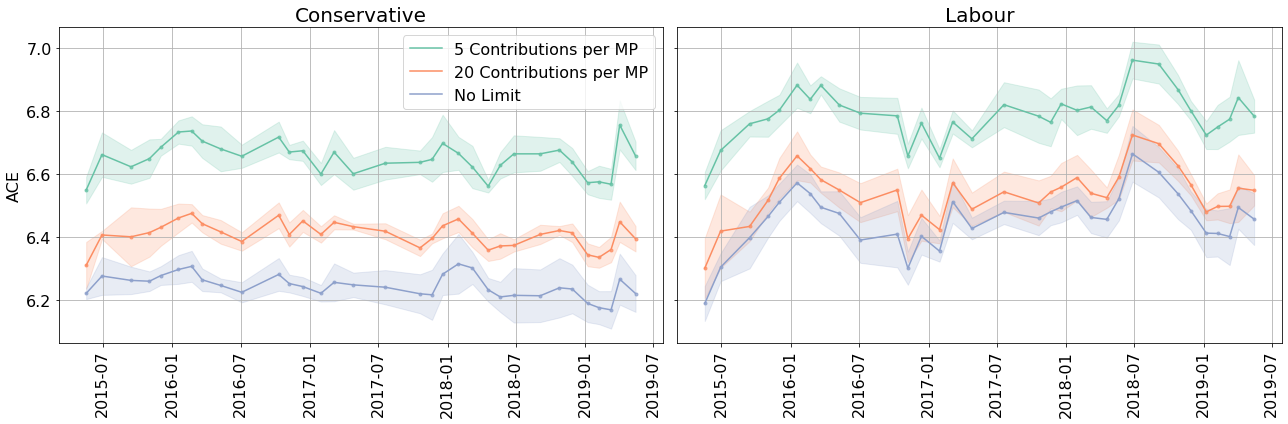

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#66c2a5", "#fc8d62", "#8da0cb"]

means, stds = get_ce_mean_and_std(comparisons_wlim_5, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[0], label="5 Contributions per MP", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_wlim_20, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[1], label="20 Contributions per MP", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_n_lim, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[2], label="No Limit", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_wlim_5, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[0], label=None, fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_wlim_20, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[1], label=None, fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_n_lim, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[2], label=None, fill_alpha=0.2)

ax1.title.set_text('Conservative')
ax2.title.set_text('Labour')

plt.setp(ax1.title, fontsize=20)
plt.setp(ax2.title, fontsize=20)

ax1.legend(fontsize=16)

plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)

ax1.set_ylabel("ACE", fontsize=16)

ax1.grid()
ax2.grid()

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "sampling_comparison.pdf"))

plt.show()

# Balancing Groups

Observing the effect of balancing the number of MPs in each sample.

### Comparison of Balanced vs Non-Balanced

With window size = 15k, window step = 5k, and sampling with a limit (n=5).

In [15]:
comparisons_bal = get_CE_comparisons(os.path.join(results_fp, "eu_CE_15000_5000_w5_lim_balanced_5_runs.json"))
comparisons_unbal = get_CE_comparisons(os.path.join(results_fp, "eu_CE_15000_5000_w5_lim_unbalanced_5_runs.json"))

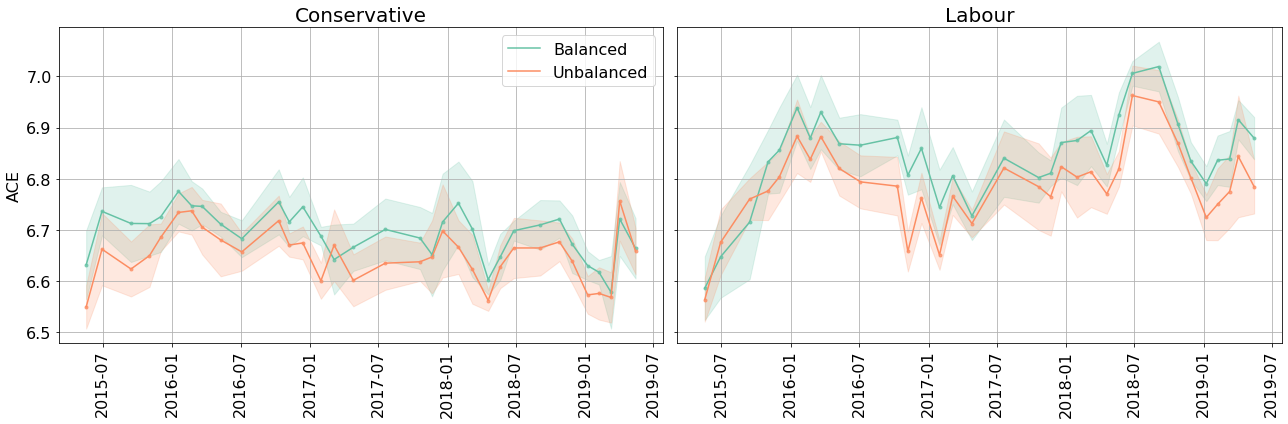

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#66c2a5", "#fc8d62", "#8da0cb"]

means, stds = get_ce_mean_and_std(comparisons_bal, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[0], label="Balanced", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_unbal, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[1], label="Unbalanced", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_bal, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[0], label=None, fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_unbal, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[1], label=None, fill_alpha=0.2)

ax1.grid()
ax2.grid()

ax1.title.set_text('Conservative')
ax2.title.set_text('Labour')

plt.setp(ax1.title, fontsize=20)
plt.setp(ax2.title, fontsize=20)

ax1.legend(fontsize=16)

plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)

ax1.set_ylabel("ACE", fontsize=16)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "balancing_comparison.pdf"))

plt.show()

With window size = 15k, window step = 5k, and sampling without limit.

In [17]:
comparisons_bal = get_CE_comparisons(os.path.join(results_fp, "eu_CE_15000_5000_n_lim_balanced_5_runs.json"))
comparisons_unbal = get_CE_comparisons(os.path.join(results_fp, "eu_CE_15000_5000_n_lim_unbalanced_5_runs.json"))

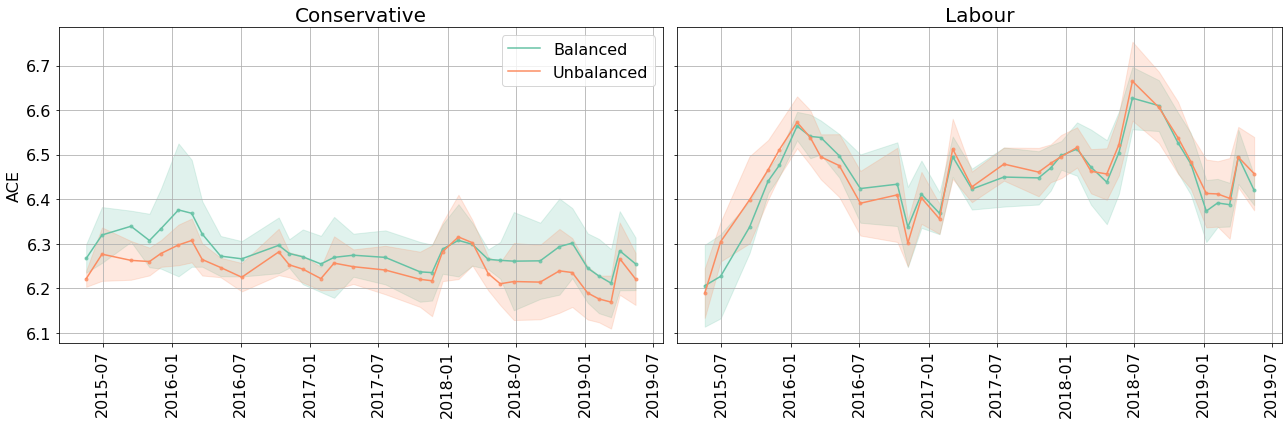

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#66c2a5", "#fc8d62", "#8da0cb"]

means, stds = get_ce_mean_and_std(comparisons_bal, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[0], label="Balanced", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_unbal, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[1], label="Unbalanced", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_bal, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[0], label=None, fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_unbal, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[1], label=None, fill_alpha=0.2)

ax1.grid()
ax2.grid()

ax1.title.set_text('Conservative')
ax2.title.set_text('Labour')

plt.setp(ax1.title, fontsize=20)
plt.setp(ax2.title, fontsize=20)

ax1.legend(fontsize=16)

plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)

ax1.set_ylabel("ACE", fontsize=16)

plt.tight_layout()

plt.show()

# Window Size

Now we will observe the effect of changing window size.

### Comparison of Window Sizes: 10k, 20k, 50k

Window step = 5k and we are using a balanced sample with limit (n=5).

In [19]:
comparisons_10k = get_CE_comparisons(os.path.join(results_fp, "eu_CE_10000_5000_w5_lim_balanced_5_runs.json"))
comparisons_20k = get_CE_comparisons(os.path.join(results_fp, "eu_CE_20000_5000_w5_lim_balanced_5_runs.json"))
comparisons_50k = get_CE_comparisons(os.path.join(results_fp, "eu_CE_50000_5000_w5_lim_balanced_5_runs.json"))

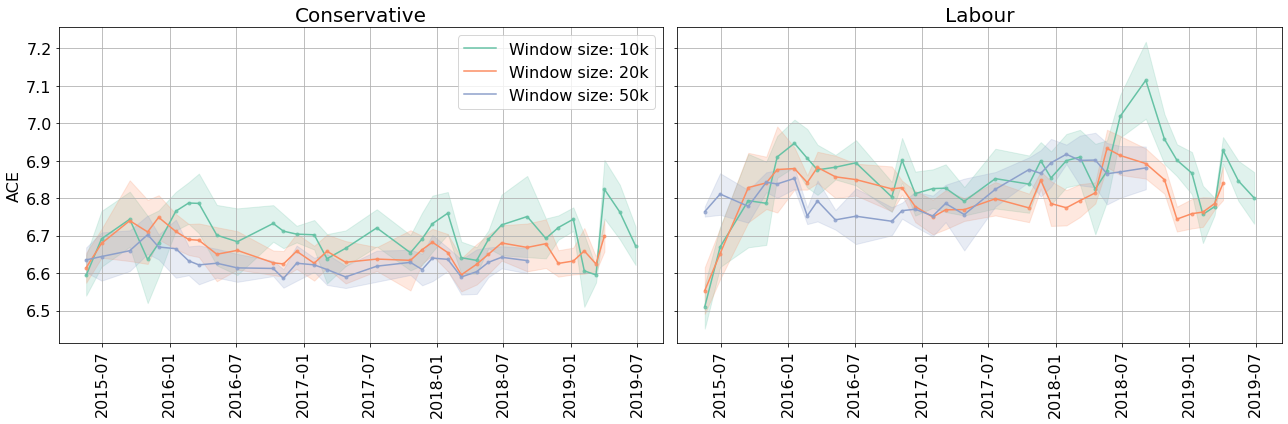

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#66c2a5", "#fc8d62", "#8da0cb"]

means, stds = get_ce_mean_and_std(comparisons_10k, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[0], label="Window size: 10k", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_20k, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[1], label="Window size: 20k", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_50k, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[2], label="Window size: 50k", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_10k, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[0], label=None, fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_20k, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[1], label=None, fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_50k, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[2], label=None, fill_alpha=0.2)

ax1.grid()
ax2.grid()

ax1.title.set_text('Conservative')
ax2.title.set_text('Labour')

plt.setp(ax1.title, fontsize=20)
plt.setp(ax2.title, fontsize=20)

ax1.legend(fontsize=16)

plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)

ax1.set_ylabel("ACE", fontsize=16)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "window_size_comparison.pdf"))

plt.show()

# Window Step

Now we will experiment with window steps.

### Comparison of Window Steps: 5k, 10k, 20k

Window size = 20k and we are using a balanced sample with a limit (n=5).

In [21]:
comparisons_5k = get_CE_comparisons(os.path.join(results_fp, "eu_CE_20000_5000_w5_lim_balanced_5_runs.json"))
comparisons_10k = get_CE_comparisons(os.path.join(results_fp, "eu_CE_20000_10000_w5_lim_balanced_5_runs.json"))
comparisons_20k = get_CE_comparisons(os.path.join(results_fp, "eu_CE_20000_20000_w5_lim_balanced_5_runs.json"))

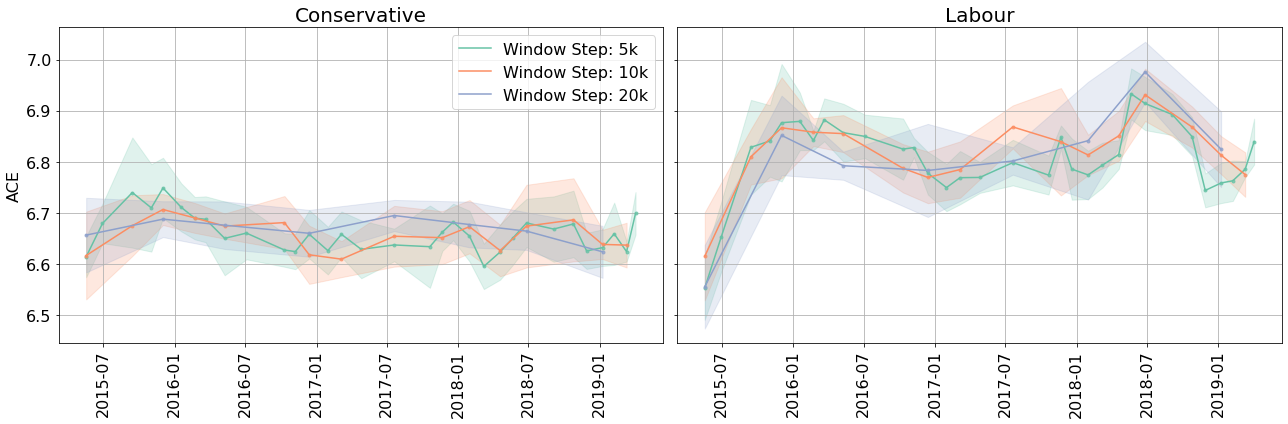

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#66c2a5", "#fc8d62", "#8da0cb"]

means, stds = get_ce_mean_and_std(comparisons_5k, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[0], label="Window Step: 5k", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_10k, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[1], label="Window Step: 10k", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_20k, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[2], label="Window Step: 20k", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_5k, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[0], label=None, fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_10k, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[1], label=None, fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_20k, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[2], label=None, fill_alpha=0.2)

ax1.grid()
ax2.grid()

ax1.title.set_text('Conservative')
ax2.title.set_text('Labour')

plt.setp(ax1.title, fontsize=20)
plt.setp(ax2.title, fontsize=20)

ax1.legend(fontsize=16)

plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)

ax1.set_ylabel("ACE", fontsize=16)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "window_step_comparison.pdf"))

plt.show()

### Comparison of Window Steps: 1k, 5k, 10k

Window size = 10k and using balanced sample with a limit (n=5).

In [23]:
comparisons_1k = get_CE_comparisons(os.path.join(results_fp, "eu_CE_10000_1000_w5_lim_balanced_5_runs.json"))
comparisons_5k = get_CE_comparisons(os.path.join(results_fp, "eu_CE_10000_5000_w5_lim_balanced_5_runs.json"))
comparisons_10k = get_CE_comparisons(os.path.join(results_fp, "eu_CE_10000_10000_w5_lim_balanced_5_runs.json"))

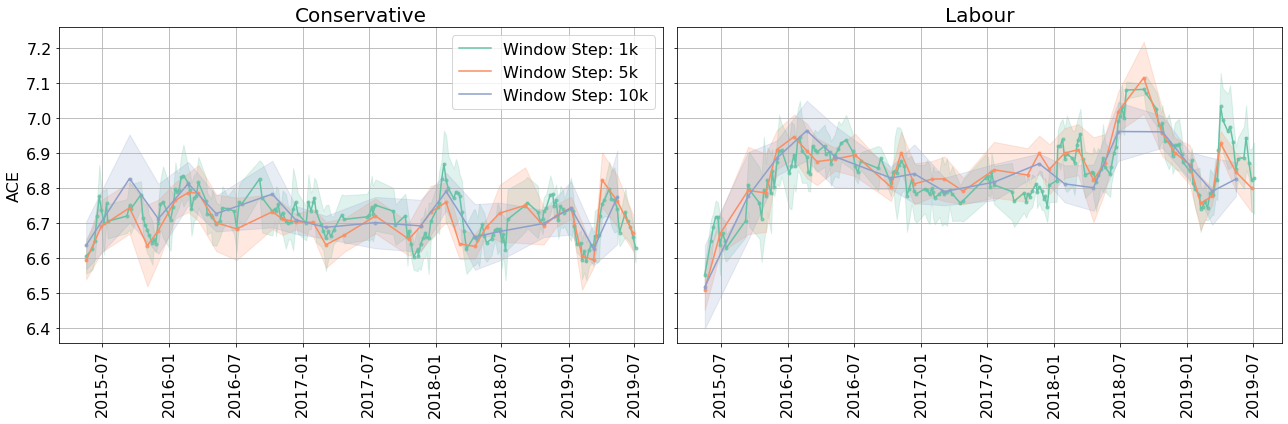

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#66c2a5", "#fc8d62", "#8da0cb"]

means, stds = get_ce_mean_and_std(comparisons_1k, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[0], label="Window Step: 1k", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_5k, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[1], label="Window Step: 5k", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_10k, "Reference", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[2], label="Window Step: 10k", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_1k, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[0], label=None, fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_5k, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[1], label=None, fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_10k, "Reference", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[2], label=None, fill_alpha=0.2)

ax1.grid()
ax2.grid()

ax1.title.set_text('Conservative')
ax2.title.set_text('Labour')

plt.setp(ax1.title, fontsize=20)
plt.setp(ax2.title, fontsize=20)

ax1.legend(fontsize=16)

plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)

ax1.set_ylabel("ACE", fontsize=16)

plt.tight_layout()

plt.show()

# First n words vs Chunking

Another hyperparameter to consider is whether to look at the first n words for each contribution, or split it into n word chunks.

In [33]:
comparisons_chunk = get_CE_comparisons(os.path.join(results_fp, "chunked.json"))
comparisons_trunc = get_CE_comparisons(os.path.join(results_fp, "truncated.json"))

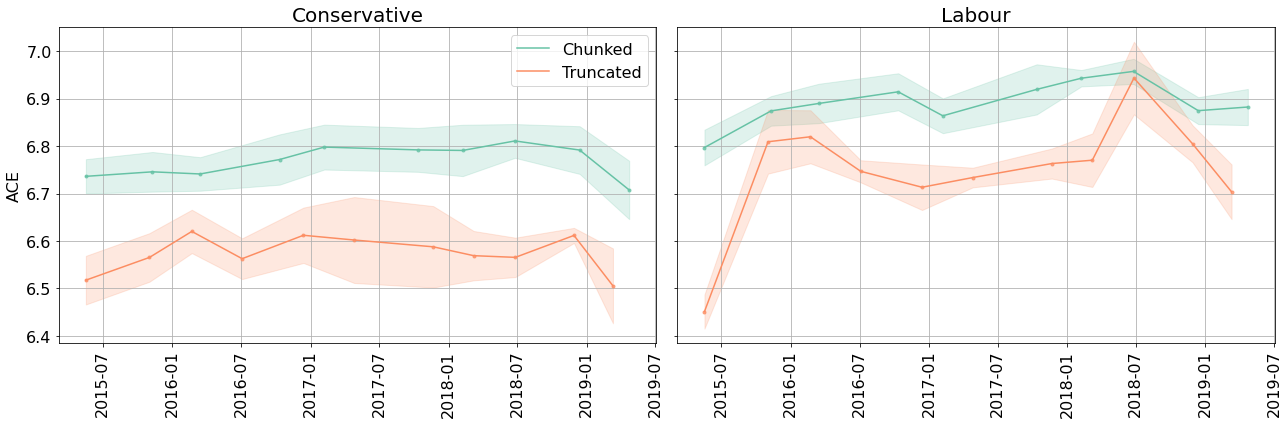

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0, wspace=0)

colour_list = ["#66c2a5", "#fc8d62", "#8da0cb"]

means, stds = get_ce_mean_and_std(comparisons_chunk, "Non-EU", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[0], label="Chunked", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_trunc, "Non-EU", "Conservative")
plot_group_similarity_across_runs_simple(means, stds, ax1, colour=colour_list[1], label="Truncated", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_chunk, "Non-EU", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[0], label=None, fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_trunc, "Non-EU", "Labour")
plot_group_similarity_across_runs_simple(means, stds, ax2, colour=colour_list[1], label=None, fill_alpha=0.2)

ax1.grid()
ax2.grid()

ax1.title.set_text('Conservative')
ax2.title.set_text('Labour')

plt.setp(ax1.title, fontsize=20)
plt.setp(ax2.title, fontsize=20)

ax1.legend(fontsize=16)

plt.setp(ax1.get_xticklabels(), fontsize=16)
plt.setp(ax2.get_xticklabels(), fontsize=16)
plt.setp(ax1.get_yticklabels(), fontsize=16)

ax1.set_ylabel("ACE", fontsize=16)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "chunking_comparison.pdf"))
plt.show()

# Visualisation

These plots will show some different ways to visualise.

### Stepped Plot

Window size & step = 15k, using balanced sample with limit (n=5).

In [27]:
comparisons_15k = get_CE_comparisons(os.path.join(results_fp, "eu_CE_15000_15000_w5_lim_balanced_5_runs.json"))

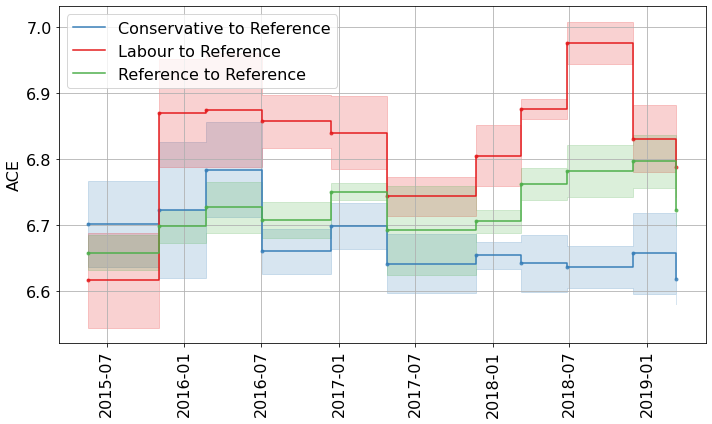

In [28]:
from mp_sampling import plot_group_similarity_across_runs_stepped

fig, ax = plt.subplots(figsize=(10, 6))

colour_list = ["#377eb8", "#4daf4a", "#e41a1c", "#984ea3"]

means, stds = get_ce_mean_and_std(comparisons_15k, "Reference", "Conservative")
plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[0], label="Conservative to Reference", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_15k, "Reference", "Labour")
plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[2], label="Labour to Reference", fill_alpha=0.2)

means, stds = get_ce_mean_and_std(comparisons_15k, "Reference", "Reference")
plot_group_similarity_across_runs_stepped(means, stds, ax, colour=colour_list[1], label="Reference to Reference", fill_alpha=0.2)

ax.grid()

plt.setp(ax.title, fontsize=20)

ax.legend(fontsize=16)

plt.setp(ax.get_xticklabels(), fontsize=16)
plt.setp(ax.get_yticklabels(), fontsize=16)

ax.set_ylabel("ACE", fontsize=16)

plt.tight_layout()

fig.savefig(os.path.join(out_fp, "stepped_example.pdf"))
plt.show()